In [1]:
from google.cloud import bigquery

In [2]:
%load_ext google.cloud.bigquery

In [3]:
bq = bigquery.Client()

In [5]:
%%bigquery
SELECT *
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE "open-lambda/%"

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,language
0,open-lambda/open-lambda,"[{'name': 'C', 'bytes': 31159}, {'name': 'Dock..."
1,open-lambda/load-balancer,"[{'name': 'C', 'bytes': 210}, {'name': 'Go', '..."


In [8]:
for col in bq.get_table("bigquery-public-data.github_repos.languages").schema:
    print(col)

SchemaField('repo_name', 'STRING', 'NULLABLE', None, None, (), None)
SchemaField('language', 'RECORD', 'REPEATED', None, None, (SchemaField('name', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('bytes', 'INTEGER', 'NULLABLE', None, None, (), None)), None)


In [9]:
%%bigquery
SELECT repo_name, language[OFFSET(0)] as first, language[OFFSET(ARRAY_LENGTH(language)-1)] as last
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE "open-lambda/%"

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,first,last
0,open-lambda/open-lambda,"{'name': 'C', 'bytes': 31159}","{'name': 'Shell', 'bytes': 1182}"
1,open-lambda/load-balancer,"{'name': 'C', 'bytes': 210}","{'name': 'Makefile', 'bytes': 1105}"


In [10]:
%%bigquery
SELECT repo_name, language[OFFSET(0)].name as first, language[OFFSET(ARRAY_LENGTH(language)-1)].name as last
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE "open-lambda/%"

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,first,last
0,open-lambda/open-lambda,C,Shell
1,open-lambda/load-balancer,C,Makefile


In [ ]:
# how often is C used with Dockerfiles?

In [18]:
%%bigquery
SELECT repo_name, L1.name AS name1, L2.name AS name2
FROM bigquery-public-data.github_repos.languages
CROSS JOIN UNNEST(language) AS L1
CROSS JOIN UNNEST(language) AS L2
WHERE repo_name LIKE "open-lambda/%"
AND L1.name = 'C' AND L2.name = 'Dockerfile'

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,name1,name2
0,open-lambda/open-lambda,Dockerfile,C


In [19]:
# what are the most common languages on GitHub?

In [21]:
%%bigquery top10
SELECT L.name, COUNT(*) as count
FROM bigquery-public-data.github_repos.languages
CROSS JOIN UNNEST(language) AS L
GROUP BY L.name
ORDER BY count DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='name'>

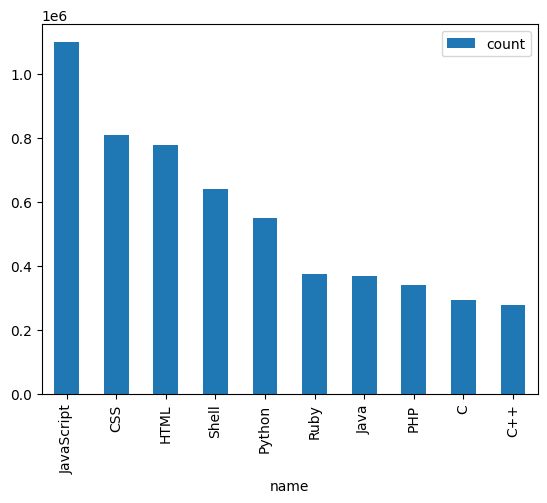

In [24]:
top10.set_index("name").plot.bar()

In [25]:
# what software licenses are used most often for Python projects?

In [27]:
%%bigquery df
SELECT licenses.license, COUNT(*) as count
FROM bigquery-public-data.github_repos.languages
CROSS JOIN UNNEST(language) AS L
INNER JOIN bigquery-public-data.github_repos.licenses ON languages.repo_name = licenses.repo_name
WHERE L.name = 'Python'
GROUP BY license
ORDER BY count DESC

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='license'>

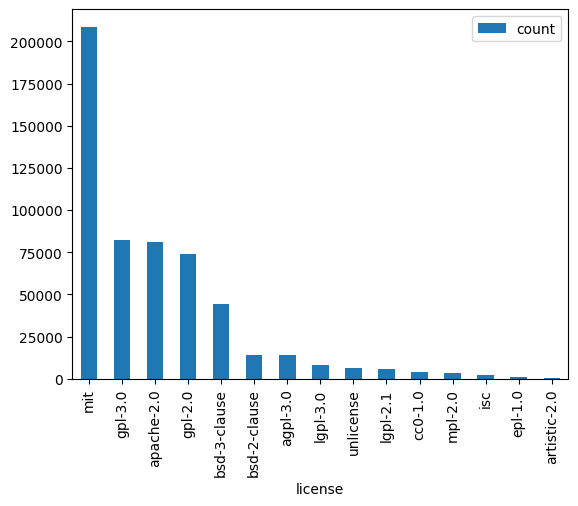

In [30]:
df.set_index("license").plot.bar()

In [32]:
# example 1: BigQuery Table
config = bigquery.LoadJobConfig(source_format="PARQUET", write_disposition="WRITE_TRUNCATE")
source = "gs://cs544nov29/hdma-wi-2021.parquet"
job = bq.load_table_from_uri(source, "cs544-f23.test2.loans", job_config=config)
job.result()

LoadJob<project=cs544-f23, location=US, id=ce5a605a-8435-4e6f-9477-b3609e42f9cd>

In [33]:
# example 2: External Table (GCS)
config = bigquery.ExternalConfig(source_format="PARQUET")
config.source_uris = ["gs://cs544nov29/hdma-wi-2021.parquet"]
# config.autodetect = True
table = bigquery.Table("cs544-f23.test2.loans-external")
table.external_data_configuration = config
bq.create_table(table, exists_ok=True)

Table(TableReference(DatasetReference('cs544-f23', 'test2'), 'loans-external'))

In [34]:
# example 3: external table (sheets)
# form: https://forms.gle/DKYMSJNkfPR8S1f46
# sheet: https://docs.google.com/spreadsheets/d/11UeIBqQylAyNUBsIO54p6WiYJWHayQMfHDbUWq1jGco/edit#gid=288285146
config = bigquery.ExternalConfig(source_format="GOOGLE_SHEETS")
config.source_uris = ["https://docs.google.com/spreadsheets/d/11UeIBqQylAyNUBsIO54p6WiYJWHayQMfHDbUWq1jGco"]
config.autodetect = True
table = bigquery.Table("cs544-f23.test2.applications")
table.external_data_configuration = config
bq.create_table(table, exists_ok=True)

Table(TableReference(DatasetReference('cs544-f23', 'test2'), 'applications'))

In [39]:
%%bigquery
SELECT COUNT(*)
FROM `cs544-f23.test2.applications`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,30


In [ ]:
# a geopandas GeoDataFrame is a subclass of pandas's DataFrame, and it has a geo column
# to_dataframe gives a pandas DataFrame
# to_geodataframe gives a geopandas GeoDataFrame

In [40]:
# FIPS code for WI is 55
wi = bq.query("""
SELECT county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""").to_geodataframe()

In [42]:
type(wi)

geopandas.geodataframe.GeoDataFrame

<Axes: >

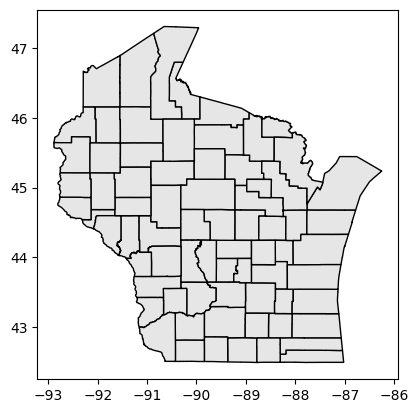

In [44]:
wi.plot(color="0.9", edgecolor="0")

In [ ]:
# export WI to our private table

In [45]:
bq.query("""
CREATE OR REPLACE TABLE `cs544-f23.test2.wi`
AS
SELECT county_name, county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""").to_geodataframe()

In [47]:
wi = bq.query("SELECT * FROM test2.wi").to_geodataframe()
wi.head(3)

,county_name,county_geom
0,Douglas,"POLYGON ((-92.20188 46.65877, -92.20175 46.657..."
1,Winnebago,"POLYGON ((-88.52479 44.24403, -88.52480 44.244..."
2,Polk,"POLYGON ((-92.75373 45.55636, -92.75341 45.556..."


In [50]:
with open("wi.geojson", "w") as f:
    f.write(wi.to_json())

In [51]:
# ST_SOME_FUNCTION (ST => Spacial Type)

<Axes: >

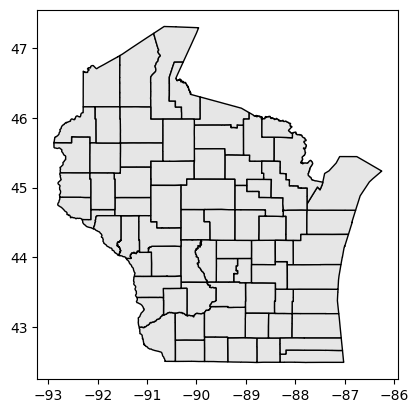

In [52]:
bq.query("SELECT * FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")

<Axes: >

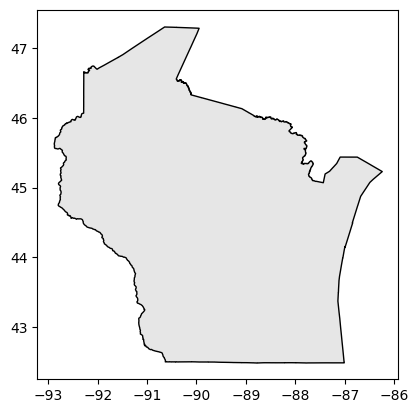

In [53]:
bq.query("SELECT ST_UNION_AGG(county_geom) FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")

<Axes: >

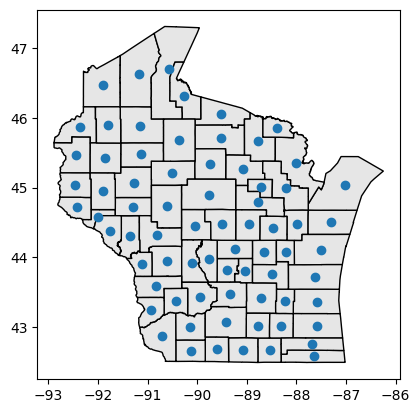

In [57]:
ax = bq.query("SELECT * FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")
bq.query("SELECT ST_CENTROID(county_geom) FROM test2.wi").to_geodataframe().plot(ax=ax)

<Axes: >

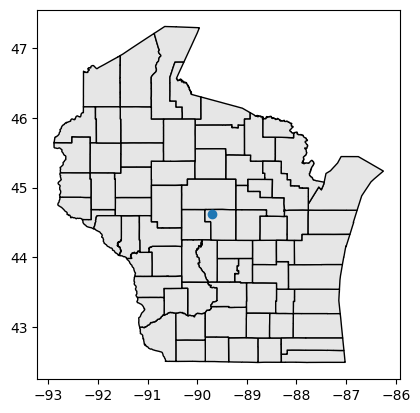

In [56]:
ax = bq.query("SELECT * FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")
bq.query("SELECT ST_CENTROID_AGG(county_geom) FROM test2.wi").to_geodataframe().plot(ax=ax)

In [62]:
bq.query("""
CREATE OR REPLACE TABLE test2.houses
AS
SELECT *, ST_GEOGPOINT(longitude, latitude) AS loc
FROM test2.applications
""").to_geodataframe()

""


<Axes: >

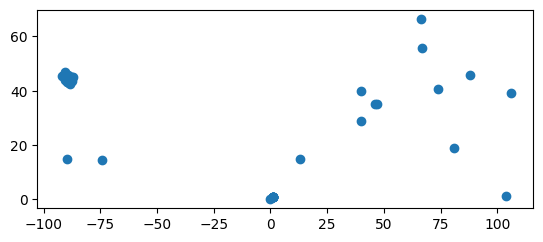

In [68]:
ax = bq.query("SELECT * FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")
bq.query("SELECT * FROM test2.houses").to_geodataframe().plot(ax=ax)

In [64]:
# what are the ten houses closest to the WI capitol?  ST_DISTANCE
# ST_GEOGPOINT(-89.384107, 43.074715)

In [66]:
%%bigquery
SELECT *, ST_DISTANCE(loc, ST_GEOGPOINT(-89.384107, 43.074715)) / 1000 AS km
FROM test2.houses
ORDER BY km ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,Timestamp,loan_amount,income,latitude,longitude,loc,km
0,2023-11-27 21:05:40.625000+00:00,100000,10000,43.069646,-89.753298,POINT(-89.7532978 43.0696456),29.993663
1,2023-11-27 21:15:51.755000+00:00,150000,20000,43.006125,-88.846895,POINT(-88.846895 43.0061248),44.320005
2,2023-11-27 21:23:37.783000+00:00,500000,34000,43.493548,-89.320734,POINT(-89.3207337 43.4935476),46.853795
3,2023-11-27 21:25:11.540000+00:00,120000,45000,43.436125,-89.899740,POINT(-89.8997396 43.4361246),57.954288
4,2023-11-27 21:14:15.019000+00:00,200000,30000,42.528472,-88.602056,POINT(-88.6020557 42.5284724),88.091206
5,2023-11-27 21:21:37.932000+00:00,400000,50000,43.812464,-88.972963,POINT(-88.9729627 43.8124645),88.494748
6,2023-11-27 21:20:00.543000+00:00,180000,30000,44.012730,-90.698655,POINT(-90.6986549 44.0127304),148.673262
7,2023-11-27 21:18:10.904000+00:00,230000,18000,43.746807,-87.723928,POINT(-87.7239278 43.7468067),153.517950
8,2023-11-27 21:17:31.994000+00:00,100000,27000,44.476759,-88.287847,POINT(-88.2878475 44.4767591),179.026351
9,2023-11-27 21:13:07.711000+00:00,300000,30000,44.523038,-88.072896,POINT(-88.0728955 44.5230382),192.374321


<Axes: >

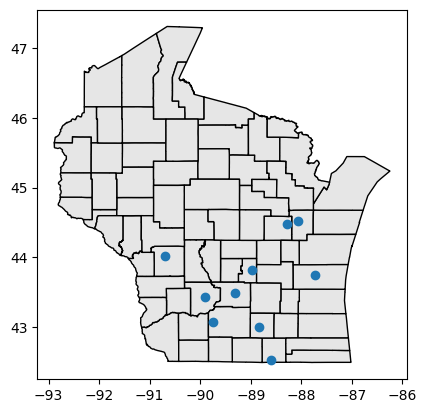

In [4]:
ax = bq.query("SELECT * FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")
bq.query("""
SELECT *, ST_DISTANCE(loc, ST_GEOGPOINT(-89.384107, 43.074715)) / 1000 AS km
FROM test2.houses
ORDER BY km ASC
LIMIT 10
""").to_geodataframe().plot(ax=ax)

In [5]:
%%bigquery
SELECT houses.*, wi.county_name
FROM test2.houses CROSS JOIN test2.wi
WHERE ST_Within(houses.loc, wi.county_geom)

Query is running:   0%|          |

Downloading:   0%|          |

,Timestamp,loan_amount,income,latitude,longitude,loc,county_name
0,2023-11-27 21:11:51.383000+00:00,200000,20000,45.000711,-87.229077,POINT(-87.229077 45.000711),Door
1,2023-11-27 21:23:37.783000+00:00,500000,34000,43.493548,-89.320734,POINT(-89.3207337 43.4935476),Columbia
2,2023-11-27 21:18:10.904000+00:00,230000,18000,43.746807,-87.723928,POINT(-87.7239278 43.7468067),Sheboygan
3,2023-11-27 21:13:07.711000+00:00,300000,30000,44.523038,-88.072896,POINT(-88.0728955 44.5230382),Brown
4,2023-11-27 21:21:37.932000+00:00,400000,50000,43.812464,-88.972963,POINT(-88.9729627 43.8124645),Green Lake
5,2023-11-27 21:17:31.994000+00:00,100000,27000,44.476759,-88.287847,POINT(-88.2878475 44.4767591),Outagamie
6,2023-11-27 21:05:40.625000+00:00,100000,10000,43.069646,-89.753298,POINT(-89.7532978 43.0696456),Dane
7,2023-11-27 21:20:00.543000+00:00,180000,30000,44.012730,-90.698655,POINT(-90.6986549 44.0127304),Monroe
8,2023-11-27 21:24:12.173000+00:00,340000,50000,44.546118,-87.694205,POINT(-87.694205 44.5461183),Kewaunee
9,2023-11-27 21:15:03.160000+00:00,300000,25000,45.233277,-88.027144,POINT(-88.0271436 45.2332774),Marinette


In [6]:
# ST_SNAPTOGRID, ST_GEOHASH

<Axes: >

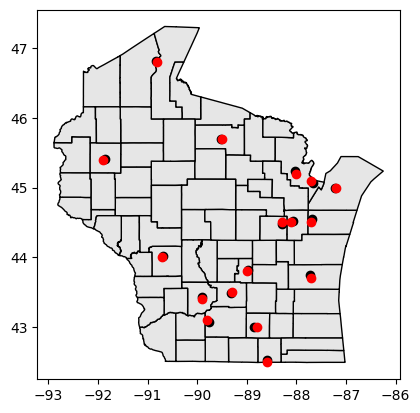

In [8]:
ax = bq.query("SELECT * FROM test2.wi").to_geodataframe().plot(color="0.9", edgecolor="0")

# exact locations:
bq.query("""
SELECT houses.*, wi.county_name
FROM test2.houses CROSS JOIN test2.wi
WHERE ST_Within(houses.loc, wi.county_geom)
""").to_geodataframe().plot(ax=ax, color="k")

# approx locations:
bq.query("""
SELECT ST_SNAPTOGRID(houses.loc, 0.1), wi.county_name
FROM test2.houses CROSS JOIN test2.wi
WHERE ST_Within(houses.loc, wi.county_geom)
""").to_geodataframe().plot(ax=ax, color="r")

In [12]:
bq.query("""
SELECT houses.loc, ST_GEOHASH(houses.loc, 3), wi.county_name
FROM test2.houses CROSS JOIN test2.wi
WHERE ST_Within(houses.loc, wi.county_geom)
""").to_dataframe()

,loc,f0_,county_name
0,POINT(-88.0728955 44.5230382),dpc,Brown
1,POINT(-87.6654045 45.0587842),f01,Marinette
2,POINT(-88.0271436 45.2332774),f01,Marinette
3,POINT(-89.5204365 45.6980241),f00,Oneida
4,POINT(-90.6986549 44.0127304),9zz,Monroe
5,POINT(-87.694205 44.5461183),dpc,Kewaunee
6,POINT(-91.8657515 45.4032143),cbn,Barron
7,POINT(-88.6020557 42.5284724),dp8,Walworth
8,POINT(-88.2878475 44.4767591),dpc,Outagamie
9,POINT(-89.3207337 43.4935476),dp8,Columbia
